# Quantum circuit Born machine (QCBM)

In this tutorial you will implement your first QCBM and train it to generate a Gaussian distribution over integers.

## Overview
We first sample a trainingset from the Gaussian distribution. 
Then, we implement an ansatz of alternating parametrized rotation layers and entangling layers. 
Finally, we optimize the parameters with respect to the <loss-function> and we test how well the distribution of the QCBM matches the Gaussian distribution.

In [1]:
from scipy.optimize import minimize
from time import time
from functools import partial
import cirq, sympy
import matplotlib.pyplot as plt
import numpy as np

## The hyperparameters

In [2]:
## Ansatz hyperparameters
n_qubits = 3
depth = 2
n_params = 2 * depth * n_qubits

# Begin with statevector simulator
shots = 0

## Sampling the trainingdata

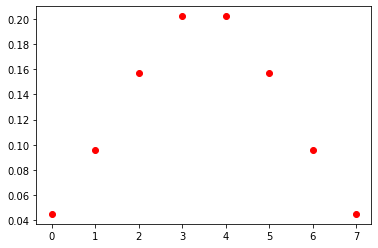

In [3]:
def gaussian_pdf(num_bit, mu, sigma):
    '''get gaussian distribution function'''
    x = np.arange(2**num_bit)
    pl = 1. / np.sqrt(2 * np.pi * sigma**2) * \
        np.exp(-(x - mu)**2 / (2. * sigma**2))
    return pl/pl.sum()

pg = gaussian_pdf(n_qubits, mu=2**(n_qubits-1)-0.5, sigma=2**(n_qubits-2))
plt.plot(pg, 'ro')
plt.show()

## Implementing the ansatz

In [4]:
# Layer of single qubit z rotations
def rot_z_layer(n_qubits, parameters):
    if n_qubits != len(parameters):
        raise ValueError("Too many or few parameters, must equal n_qubits")
    for i in range(n_qubits):
        yield cirq.Rz(2 * parameters[i])(cirq.GridQubit(i, 0))

# Layer of single qubit y rotations
def rot_y_layer(n_qubits, parameters):
    if n_qubits != len(parameters):
        raise ValueError("Too many of few parameters, must equal n_qubits")
    for i in range(n_qubits):
        yield cirq.Ry(parameters[i])(cirq.GridQubit(i, 0))

# Layer of entangling CZ(i,i+1 % n_qubits) gates.
def entangling_layer(n_qubits):
    if n_qubits == 2:
        yield cirq.CZ(cirq.GridQubit(0, 0), cirq.GridQubit(1, 0))
        return
    for i in range(n_qubits):
        yield cirq.CZ(cirq.GridQubit(i, 0), cirq.GridQubit((i+1) % n_qubits, 0))

# Variational circuit, i.e., the ansatz.
def variational_circuit(n_qubits, depth, theta):
    if len(theta) != (2 * depth * n_qubits):
        raise ValueError("Theta of incorrect dimension, must equal 2*depth*n_qubits")
    
    # Initializing qubits and circuit
    qubits = [cirq.GridQubit(i, 0) for i in range(n_qubits)]
    circuit = cirq.Circuit()
    
    # Adding layers of rotation gates and entangling gates.
    for d in range(depth):
        # Adding single qubit rotations
        circuit.append(rot_z_layer(n_qubits, theta[d * 2 * n_qubits : (d+1) * 2 * n_qubits : 2]))
        circuit.append(rot_y_layer(n_qubits, theta[d * 2 * n_qubits + 1 : (d+1) * 2 * n_qubits + 1 : 2]))
        # Adding entangling layer
        circuit.append(entangling_layer(n_qubits))
    
    return circuit

In [5]:
theta_entry_symbols = [sympy.Symbol('theta_' + str(i)) for i in range(2 * n_qubits * depth)]
theta_symbol = sympy.Matrix(theta_entry_symbols)
ansatz = variational_circuit(n_qubits, depth, theta_symbol)
print(ansatz.to_text_diagram(transpose=True))

  (0, 0)        (1, 0)        (2, 0)
  │             │             │
  Rz(2*theta_0) Rz(2*theta_2) Rz(2*theta_4)
  │             │             │
  Ry(theta_1)   Ry(theta_3)   Ry(theta_5)
  │             │             │
  @─────────────@             │
  │             │             │
  │             @─────────────@
  │             │             │
┌╴│             │             │             ╶┐
│ @─────────────┼─────────────@              │
│ │             Rz(2*theta_8) │              │
└╴│             │             │             ╶┘
  │             │             │
  Rz(2*theta_6) Ry(theta_9)   Rz(2*theta_10)
  │             │             │
  Ry(theta_7)   │             Ry(theta_11)
  │             │             │
  @─────────────@             │
  │             │             │
  │             @─────────────@
  │             │             │
  @─────────────┼─────────────@
  │             │             │


/home/casper/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Rz was used but is deprecated.
It will be removed in cirq v0.8.0.
Use cirq.rz, instead.

  
/home/casper/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: Ry was used but is deprecated.
It will be removed in cirq v0.8.0.
Use cirq.ry, instead.

  del sys.path[0]


## Implementing the Loss Function

In [6]:
# Estimate all probabilities of the PQCs distribution.
def estimate_probs(circuit, theta, n_shots=shots):
    # Creating parameter resolve dict by adding state and theta.
    try:
        theta_mapping = [('theta_' + str(i), theta[i]) for i in range(len(theta))]
    except IndexError as error:
        print("Could not resolve theta symbol, array of wrong size.")
    resolve_dict = dict(theta_mapping)
    resolver = cirq.ParamResolver(resolve_dict)
    resolved_circuit = cirq.resolve_parameters(circuit, resolver)
    
    # Use statevector simulator
    if n_shots == 0:
        final_state = cirq.final_wavefunction(resolved_circuit)
        probs = np.array([abs(final_state[i])**2 for i in range(len(final_state))])
        
    # Run the circuit.
    else:
        # Adding measurement at the end.
        resolved_circuit.append(cirq.measure(*resolved_circuit.all_qubits(), key='m'))
        results = cirq.sample(resolved_circuit, repetitions=n_shots)
        frequencies = results.histogram(key='m')
        probs = np.zeros(2**n_qubits)
        for key, value in frequencies.items():
            probs[key] = value / n_shots
    
    return probs

# Function that computes the kernel for the MMD loss
def multi_rbf_kernel(x, y, sigma_list):
    '''
    multi-RBF kernel.
    
    Args:
        x (1darray|2darray): the collection of samples A.
        x (1darray|2darray): the collection of samples B.
        sigma_list (list): a list of bandwidths.
        
    Returns:
        2darray: kernel matrix.
    '''
    ndim = x.ndim
    if ndim == 1:
        exponent = np.abs(x[:, None] - y[None, :])**2
    elif ndim == 2:
        exponent = ((x[:, None, :] - y[None, :, :])**2).sum(axis=2)
    else:
        raise
    K = 0.0
    for sigma in sigma_list:
        gamma = 1.0 / (2 * sigma)
        K = K + np.exp(-gamma * exponent)
    return K

# Function that computes expectation of kernel in MMD loss
def kernel_expectation(px, py, kernel_matrix):
    return px.dot(kernel_matrix).dot(py)

# Function that computes the squared MMD loss related to the given kernel_matrix.
def squared_MMD_loss(probs, target, kernel_matrix):
    dif_probs = probs - target
    return kernel_expectation(dif_probs,dif_probs,kernel_matrix)

# The loss function that we aim to minimize.
def loss(theta, circuit, target, kernel_matrix, n_shots=shots):
    probs = estimate_probs(circuit, theta, n_shots=n_shots)
    return squared_MMD_loss(probs, target, kernel_matrix)

# Cheat and get gradient.
def gradient(theta, target, kernel_matrix, n_shots=shots):
    prob = estimate_probs(ansatz, theta, n_shots=shots)
    grad = []
    for i in range(len(theta)):
        # pi/2 phase
        theta[i] += np.pi/2.
        prob_pos = estimate_probs(ansatz, theta, n_shots=shots)
        # -pi/2 phase
        theta[i] -= np.pi
        prob_neg = estimate_probs(ansatz, theta, n_shots=shots)
        # recover
        theta[i] += np.pi/2.
        grad_pos = kernel_expectation(prob, prob_pos, kernel_matrix) - kernel_expectation(prob, prob_neg, kernel_matrix)
        grad_neg = kernel_expectation(target, prob_pos, kernel_matrix) - kernel_expectation(target, prob_neg, kernel_matrix)
        grad.append(grad_pos - grad_neg)
    return np.array(grad)

In [7]:
# MMD kernel
basis = np.arange(2**n_qubits)
sigma_list = [0.25,4]
kernel_matrix = multi_rbf_kernel(basis, basis, sigma_list)

# Initial theta
theta0 = np.random.random(n_params)*2*np.pi

# Initializing loss function with our ansatz, target and kernel matrix
loss_ansatz = partial(loss, circuit=ansatz, target=pg, kernel_matrix=kernel_matrix)

# Callback function to track status 
step = [0]
tracking_cost = []
def callback(x, *args, **kwargs):
    step[0] += 1
    tracking_cost.append(loss_ansatz(x))
    print('step = %d, loss = %s'%(step[0], loss_ansatz(x)))

# Training the QCBM.
start_time = time()
final_params = minimize(loss_ansatz,
                        theta0, 
                        method="L-BFGS-B", 
                        jac=partial(gradient, target=pg, kernel_matrix=kernel_matrix),
                        tol=10**-5, 
                        options={'maxiter':50, 'disp': 0, 'gtol':1e-10, 'ftol':0}, 
                        callback=callback)
end_time = time()
print(end_time-start_time)

step = 1, loss = 0.14316100196289158
step = 2, loss = 0.08440857762274066
step = 3, loss = 0.06814258963291457
step = 4, loss = 0.046192077974273195
step = 5, loss = 0.018501963381051322
step = 6, loss = 0.004226420705095475
step = 7, loss = 0.002011254589633399
step = 8, loss = 0.0016714309945646824
step = 9, loss = 0.001393748695381338
step = 10, loss = 0.0009725148906202676
step = 11, loss = 0.0006228965941684052
step = 12, loss = 0.00044505640080219736
step = 13, loss = 0.0002456842381173457
step = 14, loss = 0.00023773055833462763
step = 15, loss = 0.00017031406477115813
step = 16, loss = 0.00014949208735561874
step = 17, loss = 0.00010857848321752927
step = 18, loss = 9.046478293152856e-05
step = 19, loss = 6.399932474980324e-05
step = 20, loss = 4.897463290484894e-05
step = 21, loss = 4.1633627323200655e-05
step = 22, loss = 3.5902733254633684e-05
step = 23, loss = 3.0399670151340435e-05
step = 24, loss = 2.6420557442611562e-05
step = 25, loss = 2.2346237766263288e-05
step = 26,

## Looking at final parameters, its cost function and the generated distribution.

In [8]:
final_params

      fun: 1.4697311812174217e-05
 hess_inv: <12x12 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.00000000e+00, -1.79241186e-07,  0.00000000e+00, -7.89987431e-09,
        0.00000000e+00,  4.43426241e-08,  0.00000000e+00,  1.09666788e-07,
        0.00000000e+00, -3.56061365e-08,  0.00000000e+00,  5.79055581e-09])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 61
      nit: 40
   status: 0
  success: True
        x: array([1.43085857, 4.71294603, 3.86389339, 5.81117531, 0.49743146,
       0.2151291 , 4.28464128, 6.28417168, 6.19759606, 4.71266256,
       0.02028919, 1.57070521])

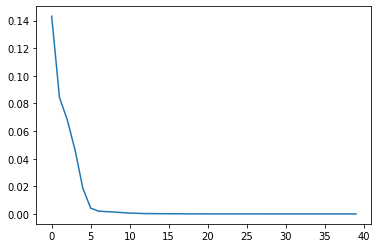

In [9]:
plt.plot(list(range(len(tracking_cost))), tracking_cost)

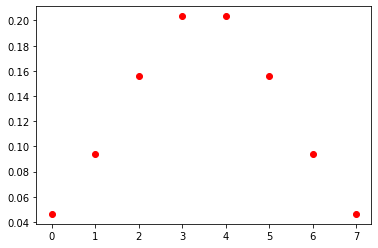

In [11]:
plt.plot(estimate_probs(ansatz, final_params.x), 'ro')